In [5]:
!pip install -r ../requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 83.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Uncomment the lines below to download the data from the Zenodo repositories and 
# unzip it in the data folder

%cd ../data

# !wget https://zenodo.org/record/7576814/files/source.zip?download=1 -O source.zip
# !unzip source.zip
# !rm source.zip
# !mv source/WEIGHTS .
# !rm -r source

!wget https://zenodo.org/records/15120875/files/data.zip?download=1 -O data.zip
!unzip data.zip
!rm data.zip

%cd ../src

/home/onyxia/work/StatApp/data
--2025-04-28 06:07:54--  https://zenodo.org/records/15120875/files/data.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48582379729 (45G) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]  45.25G  61.0MB/s    in 8m 30s  

2025-04-28 06:16:24 (90.9 MB/s) - ‘data.zip’ saved [48582379729/48582379729]

Archive:  data.zip
   creating: data/
  inflating: data/solar_panel_data_madagascar.xlsx  
   creating: data/img/
 extracting: data/img/.getxfer.904634.1.mega  
 extracting: data/img/.getxfer.904634.2.mega  
 extracting: data/img/.getxfer.904634.3.mega  
 extracting: data/img/.getxfer.904634.4.mega  
 extracting: data/img/.getxfer.904634.5.mega  
 extracting: data/img/.getxfer.904634.6.mega  
 extracting: data/img/.getxfer.904634.7.mega  

In [7]:
from dataset import SolarPanelDataset
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [8]:

data_path = Path("../data")

xlsx_path = data_path / "solar_panel_data_madagascar.xlsx"
img_path = data_path / "img"
seg_weights_path = data_path / "WEIGHTS" / "model_bdappv_seg.pth"

dataset = SolarPanelDataset(img_path, xlsx_path, "seg", "pan", p=1, train=False, seed=0)

In [9]:
model = torch.load(seg_weights_path, weights_only=False)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [10]:
img, mask = dataset[0]

threshold = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
predicted = model.forward(img.unsqueeze(0).to(device))

prediction = predicted['out']
prediction = (prediction - torch.min(prediction)) / (torch.max(prediction) - torch.min(prediction) + 0.000000001)
binary_output = (prediction >= threshold).long().squeeze(1).detach().cpu().numpy()[0]

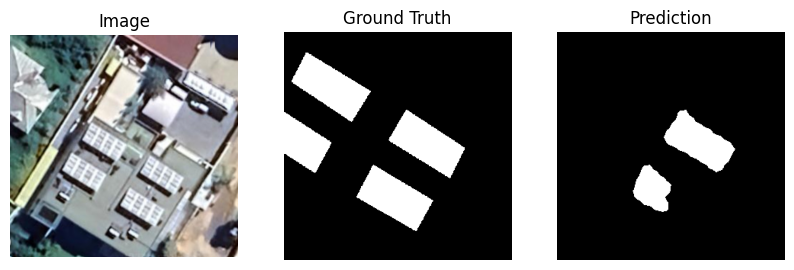

In [11]:
raw_img = cv2.imread("../data/img/1.jpg")
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

img_np = img.permute(1, 2, 0).numpy()
mask_np = mask.squeeze().numpy()
binary_output_np = binary_output.squeeze()

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(raw_img)
axes[0].axis("off")
axes[0].set_title("Image")

axes[1].imshow(mask_np, cmap="gray")
axes[1].axis("off")
axes[1].set_title("Ground Truth")

axes[2].imshow(binary_output_np, cmap="gray")
axes[2].axis("off")
axes[2].set_title("Prediction")

plt.show()